<a href="https://colab.research.google.com/github/ShkarupyloMaksym/Sigmoindus_retina_model/blob/main/Sigmoindus_retina_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iasa-champ-24-ui-element-sketch-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F68289%2F7586851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240406%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240406T111123Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D92e66545e8b50a4815a435477742123eeb7d45de6418d8c4a435cdeb8c8ea51dc4d9288d659be5a8de2f949bd3610922292b3068be9fdb26574ad4a595d792dd7ba7e76124bbd25535b91a510d3f3138daa7175b9fb523e65065600bc38b1c06f93d262718d865e3783e9c29ed11f6214267883ca4a87018f0a9dac17c984d34074eb1e8698bd9efd25d76a9f083b8fea7fb4e58b250881c1c27a965125741c55d6a3076a49ed3cc6a4a35bc2c720241a95aac8d6f0791be9c210f993b38981cd629c59788a4954569a1c121b3c403e7127a5d115f0e73d987ffd71c80bd3437d497c1b951cf864562d0afbe7225649721378ac66f91964c243f61b727e2bf3d,weights:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4391923%2F7542007%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240406%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240406T111123Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D05cc1cc67d2eeacac5609e368411213b7de5d07afeea4b8706b4a95519398f6a85f5dbe143defbb556a73202854f177694ee964fd1c1af6f139f356b12d176da3d04081f3e502f1887f2848f8a32b5d538a66bdb3eef86b3b4158f62d656ef85d3d871c8ef7cf62bc4b258d80c1fa5f0f94eb74500ed30b62671759d18181c6937391155828a34c0186ecc3da672d38120eaa054465e67c18dbb290f4213c0b6d75272e8a44964c0aac975e6ab9f49c346996b26e566be8b65d441cfa39c36689dcb09e1770328559b0bc0c19afe0a157125f505a641476c9469c50927544de057188bb793f13380f345b71a6ea5b1874f89c5597f109cd2f605e1f50d2c80a8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
!pip install tensorflow_addons

# Imports


In [ ]:
import os
import shutil
import pathlib
import zipfile
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from functools import partial
from matplotlib import pyplot as plt
from keras.utils import plot_model
from keras.optimizers import schedules
from keras.optimizers import Adam, Nadam
from keras.layers import Dense, Dropout, GaussianDropout, Input, Conv2D, Flatten, MaxPool2D, AvgPool2D, Concatenate, BatchNormalization, Activation
from keras.models import Model
from keras import activations
from keras.losses import CategoricalCrossentropy
from keras.applications.efficientnet import EfficientNetB4, EfficientNetB2
from keras.applications.efficientnet import preprocess_input

from keras import regularizers
import tensorflow_addons as tfa

import seaborn as sns
from keras.preprocessing import image
import random
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Some functions

## NN functions


### Retina-like layers

Retina-like layers use several convolution kernels in parallel to imitate human retina with fovea (small kernels) and surrounding low-quality region (convolutions with dilation rate more than 1 preceded by pooling layer that collects values from some area into one pixel).

Is a product of work of Kosenko and Shkarupylo, which can be wisited here: https://github.com/KosenkoAlexander/RetinaBased .

In [ ]:
def retina_like(input_layer, kernel_size, filters_regular,
                filters_atrous,
                vision_rate=3, pool_function=AvgPool2D, activation=None,
                skip=False):
    '''Implements retina_like layer which has central high-resolution region surrounded by larger low-resolution region.

    Args:
    input_layer: output of previous layer
    kernel_size: size of high resolution region
    filters_regular: number of filters applied to high-resolution region
    filters_atrous: number of filters applied to low-resolution region
    vision_rate: relative size of low-resolution field (it's actual size is vision_rate*kernel_size)
    pool_function: pooling used for making low-resolution region
    activation: activation applied to convolutions
    skip: adds skip connections

    Returns:
    output of layer, shape equals input_layer shape with channel dimension replaced by filters_regular+filters_atrous
    '''
    conv_regular = Conv2D(filters_regular, kernel_size, padding='same', activation=activation)(input_layer)

    pool = pool_function((kernel_size, kernel_size), strides=(1, 1), padding='same')(input_layer)
    conv_atrous = Conv2D(filters_atrous, vision_rate, dilation_rate=kernel_size, padding='same', activation=activation)(
        pool)

    return Concatenate()([conv_regular, conv_atrous] + ([input_layer] if skip else []))

In [ ]:
def retina_generalized(input_layer, filters_list, kernelsize_list, poolsize_list, dilation_list=None, activation=None, pool_function=AvgPool2D, skip=False, batch_normalization=False, kernel_regularizer=None):
    '''Implements retina_like layer which has central high-resolution region surrounded by larger low-resolution region.

    Args:
    input_layer: output of previous layer
    filters_list: list of filter number
    kernelsize_list: list of kernel sizes
    poolsize_list: list of pooling sizes (before corresponding convolution layer, has strides 1)
    dilation_list: list of convolution dilations, if absent equals to poolsize_list
    activation: activation function list (one for each convolution layer) or one activation function (will be used for all convolution layers)
    pool_fuction: pooling function to use before convolution layers with corresponding value of poolsize_list more than 1
    skip: add skip connection
    batch_normalization: add batch normalization
    kernel_regularizer: kernel regularizer for all convolution layers

    Returns:
    output of layer, shape equals input_layer shape with channel dimension replaced by filters_regular+filters_atrous
    '''
    if activation is None:
        activation = ['relu' for _ in filters_list]
    elif not isinstance(activation,list):
      activation = [activation for _ in filters_list]

    if dilation_list is None:
        dilation_list = poolsize_list



    concat_list=[]

    for filters, kernelsize, poolsize, dilation, activation in zip(filters_list, kernelsize_list, poolsize_list, dilation_list, activation):
        pool=input_layer
        if poolsize != 1:
            pool=pool_function(poolsize, strides=1, padding='same')(pool)
        conv=Conv2D(filters, kernelsize, dilation_rate=dilation, padding='same', kernel_regularizer=kernel_regularizer)(pool)
        if batch_normalization: conv=BatchNormalization()(conv)
        conv=Activation(activation=activation)(conv)
        concat_list.append(conv)

    return Concatenate()(concat_list + ([input_layer] if skip else []))


In [ ]:
def deep_retina_like(input_layer, kernel_size, filters_regular,
                     filters_atrous,
                     filters_activations_list,
                     vision_rate=3, pool_function=AvgPool2D, activation_retina=None,
                     skip=False):
    '''Implements retina_like layer with 1x1 convolutions stacked on top of it.

    Args:
    input_layer: output of previous layer
    kernel_size: size of high resolution region
    filters_regular: number of filters applied to high-resolution region
    filters_atrous: number of filters applied to low-resolution region
    filters_activations_list: list of (filters, activation) typles which provide number of filters and activation functions for 1x1 convolution layers added on top of retina_like
    vision_rate: relative size of low-resolution field (it's actual size is vision_rate*kernel_size)
    pool_function: pooling used for making low-resolution region
    activation_retina: activation applied to convolutions of retina_like
    skip: adds skip connections

    Returns:
    output of layer, shape equals input_layer shape with channel dimension replaced by filters of last tuple in filters_activations_list
    '''
    input_layer = retina_like(input_layer, kernel_size, filters_regular, filters_atrous, vision_rate, pool_function,
                              activation=activation_retina, skip=skip)
    for filters_activations in filters_activations_list:
        input_layer = Conv2D(filters_activations[0], 1, activation=filters_activations[1])(input_layer)
    return input_layer

## Data functions

In [ ]:
def show_train_graphs(history, metrics=['accuracy', 'loss'], figsize=(15, 5), column_num=2):
    plt.figure(figsize=figsize)
    row_num = int(np.ceil(len(metrics)/column_num))
    for i, metric in enumerate(metrics):
        plt.subplot(row_num, column_num, i+1)
        plt.plot(history.history[metric], label='train')
        plt.plot(history.history['val_' + metric], label='validation')
        plt.legend()
        plt.title(metric)

    plt.show()

In [ ]:
def plot_inccorectly_predicted_data(max_images):
  class_indices = validation_data.class_indices
  index_to_class = {v: k for k, v in class_indices.items()}
  incorrect_indices = np.where(y_pred != y_true)[0]
  incorrect_indices = incorrect_indices[:max_images]
  n_rows = (len(incorrect_indices) + 4 - 1) // 4
  plt.figure(figsize=(20, n_rows * 5))
  for i, index in enumerate(incorrect_indices):
      true_label_index = y_true[index]
      pred_label_index = y_pred[index]
      true_label_name = index_to_class[true_label_index]
      pred_label_name = index_to_class[pred_label_index]
      img_path = validation_data.filepaths[index]
      img = image.load_img(img_path, target_size=(224, 224))

      plt.subplot(n_rows, 4, i + 1)  # Adjust number of columns as needed
      plt.imshow(img)
      plt.title(f"True: {true_label_name}, Pred: {pred_label_name}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def show_prediction_results_deployed(model, test_data):
  result = model.predict(validation_data,batch_size = 16,verbose = 0)
  y_pred = np.argmax(result, axis = 1)
  y_true = validation_data.labels

  data = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, )).T
  data = data.applymap(lambda x: round(x,4))

  display(data)

  confusion_mtx = confusion_matrix(y_true,y_pred)

  f,ax = plt.subplots(figsize = (8,4),dpi=200)
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, fmt='.0f', ax=ax,cbar=False, xticklabels=class_names,
              yticklabels=class_names)

  plt.show()

In [ ]:
def plot_classes():
  plt.figure(figsize=(15, 10))

  for i, class_name in enumerate(class_names):
      class_dir = os.path.join(path_to_train_dir, class_name)
      image_names = os.listdir(class_dir)
      random.shuffle(image_names)
      image_name = image_names[0]
      image_path = os.path.join(class_dir, image_name)
      img = Image.open(image_path)
      plt.subplot(5, 5, i + 1)
      plt.imshow(img)
      plt.title(class_name)
      plt.axis('off')

  plt.tight_layout()
  plt.show()


# Some constants

In [ ]:
image_size = (224, 224)

train_validation_size = 0.2

In [ ]:
path_to_data_dir_abs = os.path.join('/kaggle', 'input', 'iasa-champ-24-ui-element-sketch-classification', 'ui_icons_dataset', 'ui_icons_dataset')
path_to_train_dir = os.path.join(path_to_data_dir_abs, 'train')
path_to_test = os.path.join(path_to_data_dir_abs, 'test')

# Download, extract, import, show data

In [ ]:
class_names = os.listdir(path_to_train_dir)
class_names.sort()

## Import data

In [ ]:
generator = ImageDataGenerator(validation_split=train_validation_size)
train_data = generator.flow_from_directory(path_to_train_dir,
                                           target_size=image_size,
                                           color_mode='grayscale',
                                           batch_size=64,
                                           subset='training')
validation_data = generator.flow_from_directory(path_to_train_dir,
                                           target_size=image_size,
                                           color_mode='grayscale',
                                           batch_size=64,
                                           subset='validation', shuffle=False)

Found 12325 images belonging to 21 classes.
Found 3074 images belonging to 21 classes.


## Show data

In [ ]:
show_data = False
if(show_data):
  for _ in range(5):
    img, label = train_data.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0], cmap='gray')
    plt.show()


In [ ]:
plot_classes()

# Model

## Initialize

$\underset{size}{max}(\underset{size}{argmax}(min(\frac{150}{size}, 10))) = 15$, so we limited our model size to at most 15 MB.

### Model description

This model uses mainly retina-like layers described earlier. These have large receptive fields when image is 55x55 and 27x27 pixels in size. After that receptive fields are decreased but retina-like layers are still used to reap benefits of parallel kernels of different size. Before that retina-generalized is used only to introduce larger kernels in parallel with 3x3 kernels, this is done in order to collect more sparse (since sketches have sparse) features. Final two layers of the network are dense.

Between most retina-like layers there are 1x1 convolution layers to reduce number of connections and size of the model, since placing 1x1 convolution layer with $n_{1x1}$ channels between layers with channel numbers $n_{prev}$ and $n_{next}$ and kernel size of second layer $k_{next}\times k_{next}$ changes size of weights needed to represent second layers kernel from $n_{prev}\cdot n_{next}\cdot k_{next}\cdot k_{next}$ to $n_{prev}\cdot n_{1x1}+n_{1x1}\cdot n_{next}\cdot k_{next}\cdot k_{next}$. This idea is inspired by SqueezeNetand it's fire modules (https://arxiv.org/pdf/1602.07360.pdf).

In [ ]:
default_conv_regularizer=regularizers.L1L2(l1=1e-5, l2=3e-3)
def RetinaModel():
  inp=Input(image_size+tuple([1]))
  x=BatchNormalization()(inp)
  x=Conv2D(32,3,activation=activations.elu)(x)
  x=AvgPool2D(2)(x)
  x=retina_generalized(x, [32,32], [3,5],[1,1], batch_normalization=True,activation=activations.gelu)
  x=AvgPool2D(2)(x)
  x=retina_generalized(x, [16,32,32,32,16], [1,3,3,5,3],[1,1,3,1,5], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x=retina_generalized(x, [16,32,32,32,16], [1,3,3,5,3],[1,1,3,1,5], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x=AvgPool2D(2)(x)
  x=retina_generalized(x, [48,64,32,48,32], [1,3,3,5,3],[1,1,3,1,5], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x=Conv2D(64,1,activation=activations.elu)(x)
  x=retina_generalized(x, [64,96,48,64,48], [1,3,3,5,3],[1,1,3,1,5], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x=Conv2D(64,1,activation=activations.elu)(x)
  x=retina_generalized(x, [64,96,64,96,32], [1,3,3,5,3],[1,1,3,1,5], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x=Conv2D(64,1,activation=activations.elu)(x)
  x2=x=AvgPool2D(2)(x)
  x=retina_generalized(x, [64,128,96], [1,3,3],[1,1,3], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x3=x=Conv2D(64,1,activation=activations.elu)(x)
  x=retina_generalized(x, [96,128,96], [1,3,3],[1,1,3], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x4=x=Conv2D(64,1,activation=activations.elu)(x)
  x=retina_generalized(x, [96,128,96], [1,3,3],[1,1,3], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x=Concatenate()([x,x2,x3,x4])
  x=AvgPool2D(2)(x)
  x2=x=Conv2D(64,1,activation=activations.elu)(x)
  x=retina_generalized(x, [96,128,64], [1,3,3,3],[1,1,1,1],[1,1,3,5], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x3=x=Conv2D(64,1,activation=activations.elu)(x)
  x=retina_generalized(x, [96,192,96], [1,3,3,3],[1,1,1,1],[1,1,3,5], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x4=x=Conv2D(96,1,activation=activations.elu)(x)
  x=retina_generalized(x, [128,192,96], [1,3,3,3],[1,1,1,1],[1,1,3,5], batch_normalization=True, kernel_regularizer=default_conv_regularizer,activation=activations.gelu)
  x=Concatenate()([x,x2,x3,x4])
  x=Conv2D(256,1,activation=activations.elu)(x)
  x=Flatten()(x)
  x = Dropout(0.7)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.7)(x)
  x = Dense(21,activation='softmax',kernel_regularizer=regularizers.L1L2(l1=1e-6, l2=1e-4))(x)
  model = Model(inputs=inp, outputs=x)
  schedule=schedules.ExponentialDecay(initial_learning_rate=0.0002, decay_steps=400, decay_rate=0.9)
  model.compile(Nadam(learning_rate=schedule),
                      loss='categorical_crossentropy',
                      metrics=[
                          'accuracy',
                          tfa.metrics.F1Score(num_classes=21, average=None,)
                      ]
                      )
  return model

In [ ]:
model = RetinaModel()

### Show

In [ ]:
model.summary(show_trainable=True)

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            Y          
                                                                                                             
 batch_normalization (Batch  (None, 224, 224, 1)          4         ['input_1[0][0]']             Y          
 Normalization)                                                                                              
                                                                                                             
 conv2d (Conv2D)             (None, 222, 222, 32)         320       ['batch_normalization[0][0]   Y          
                                                                    ']                                   

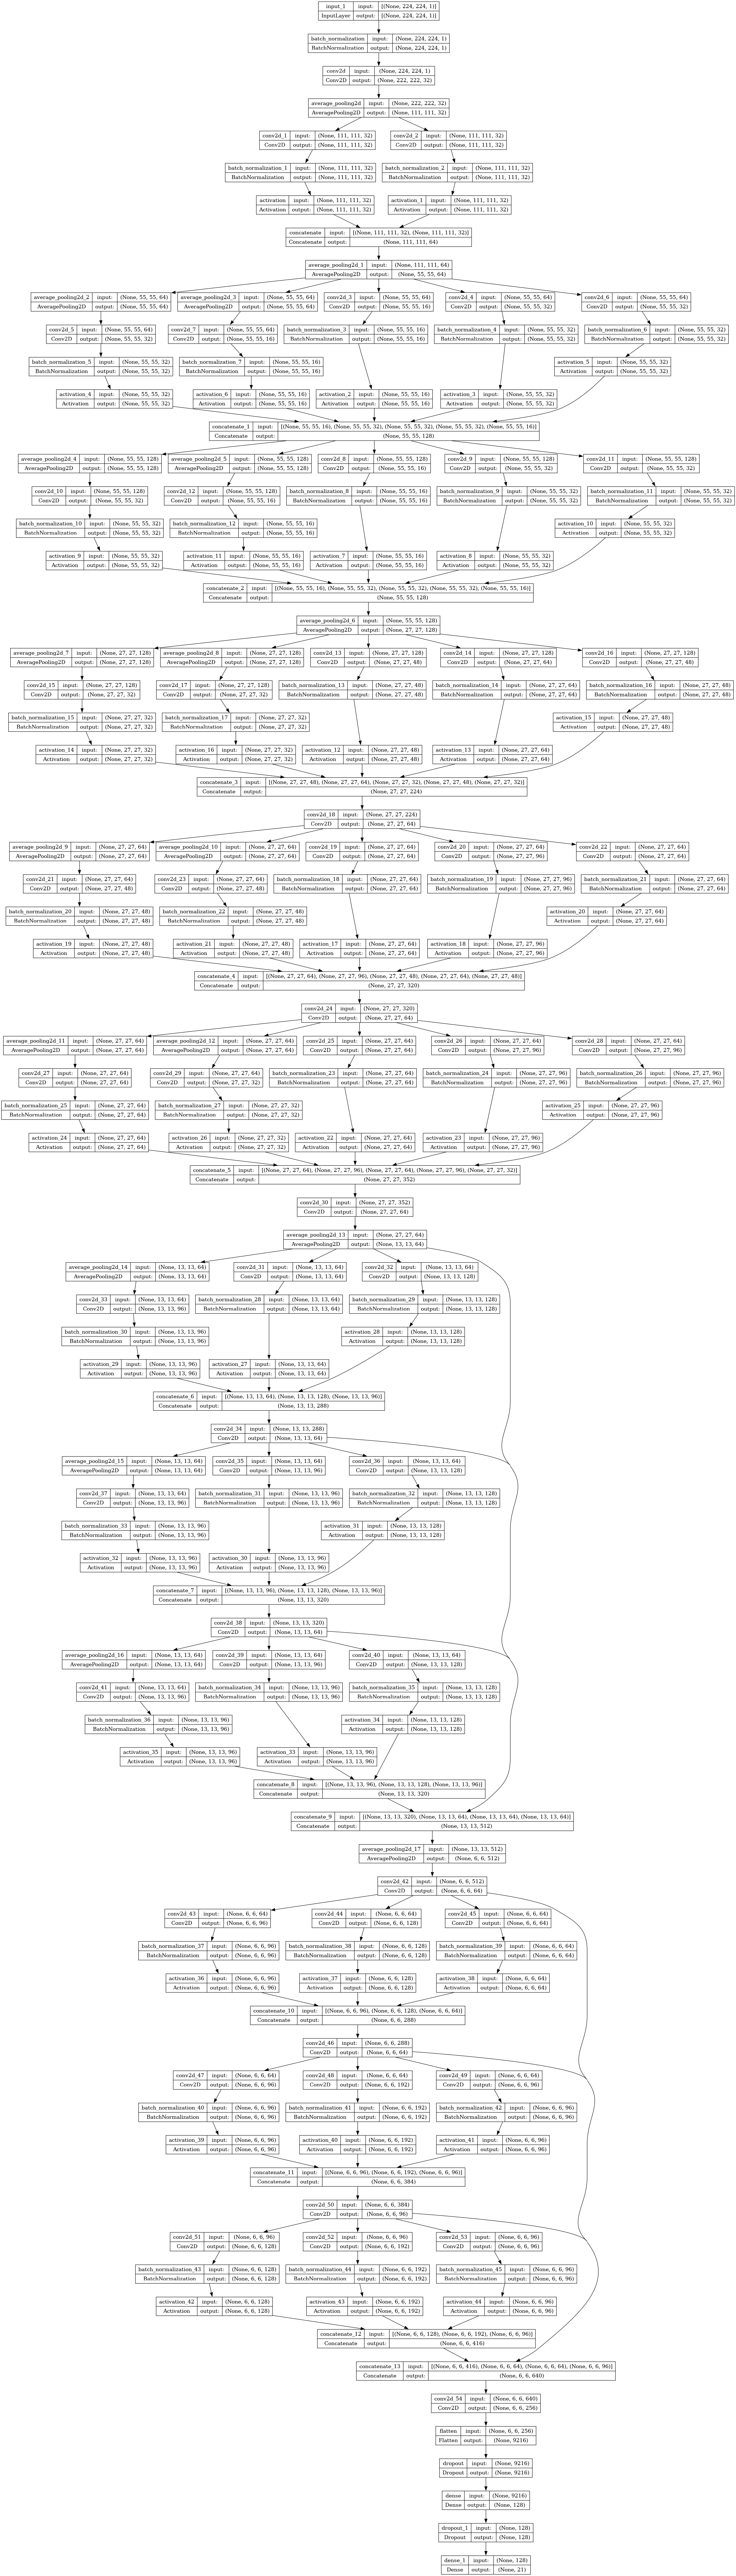

In [ ]:
plot_model(model, show_shapes=True)

## Training

In [ ]:
epochs = 20

In [ ]:
from keras.callbacks import ModelCheckpoint
path_to_checkpointer = os.path.join(f'Some.model.{epochs}.hdf5')
checkpointer = ModelCheckpoint(filepath=path_to_checkpointer, save_best_only=True, save_weights_only=True)

In [ ]:
history = model.fit(train_data,
                   validation_data=validation_data,
                    epochs=epochs, verbose=1, callbacks=[checkpointer])

Epoch 1/20

193/193 [==============================] - 203s 629ms/step - loss: 11.9685 - accuracy: 0.1520 - f1_score: 0.1447 - val_loss: 11.7786 - val_accuracy: 0.0924 - val_f1_score: 0.0578

Epoch 2/20

193/193 [==============================] - 104s 541ms/step - loss: 10.7881 - accuracy: 0.3237 - f1_score: 0.3129 - val_loss: 10.1598 - val_accuracy: 0.4288 - val_f1_score: 0.4038

Epoch 3/20

193/193 [==============================] - 107s 554ms/step - loss: 9.8794 - accuracy: 0.4289 - f1_score: 0.4197 - val_loss: 9.1011 - val_accuracy: 0.5742 - val_f1_score: 0.5562

Epoch 4/20

193/193 [==============================] - 104s 540ms/step - loss: 9.1351 - accuracy: 0.4926 - f1_score: 0.4869 - val_loss: 8.5947 - val_accuracy: 0.5709 - val_f1_score: 0.5608

Epoch 5/20

193/193 [==============================] - 105s 541ms/step - loss: 8.4887 - accuracy: 0.5441 - f1_score: 0.5417 - val_loss: 7.9452 - val_accuracy: 0.6288 - val_f1_score: 0.6269

Epoch 6/20

193/193 [=========================

In [ ]:
history1 = model.fit(train_data,
                   validation_data=validation_data, epochs=epochs*2, initial_epoch=epochs, verbose=1, callbacks=[checkpointer])

Epoch 21/40

193/193 [==============================] - 107s 555ms/step - loss: 3.9369 - accuracy: 0.8496 - f1_score: 0.8511 - val_loss: 4.1991 - val_accuracy: 0.8032 - val_f1_score: 0.8020

Epoch 22/40

193/193 [==============================] - 104s 541ms/step - loss: 3.8148 - accuracy: 0.8619 - f1_score: 0.8631 - val_loss: 4.0889 - val_accuracy: 0.8035 - val_f1_score: 0.8017

Epoch 23/40

193/193 [==============================] - 104s 540ms/step - loss: 3.7165 - accuracy: 0.8726 - f1_score: 0.8739 - val_loss: 3.9739 - val_accuracy: 0.8221 - val_f1_score: 0.8236

Epoch 24/40

193/193 [==============================] - 107s 554ms/step - loss: 3.6264 - accuracy: 0.8804 - f1_score: 0.8819 - val_loss: 4.0091 - val_accuracy: 0.8178 - val_f1_score: 0.8177

Epoch 25/40

193/193 [==============================] - 107s 554ms/step - loss: 3.5312 - accuracy: 0.8875 - f1_score: 0.8890 - val_loss: 3.9203 - val_accuracy: 0.8201 - val_f1_score: 0.8193

Epoch 26/40

193/193 [=======================

In [ ]:
history1 = model.fit(train_data,
                   validation_data=validation_data, epochs=epochs*2, initial_epoch=epochs, verbose=1, callbacks=[checkpointer])

In [ ]:
history2 = model.fit(train_data,
                   validation_data=validation_data, epochs=epochs*2, initial_epoch=epochs, verbose=1, callbacks=[checkpointer])

Epoch 21/40

193/193 [==============================] - 104s 539ms/step - loss: 2.7060 - accuracy: 0.9663 - f1_score: 0.9666 - val_loss: 3.6996 - val_accuracy: 0.8318 - val_f1_score: 0.8324

Epoch 22/40

193/193 [==============================] - 104s 541ms/step - loss: 2.6643 - accuracy: 0.9754 - f1_score: 0.9757 - val_loss: 3.7441 - val_accuracy: 0.8250 - val_f1_score: 0.8255

Epoch 23/40

193/193 [==============================] - 104s 539ms/step - loss: 2.6428 - accuracy: 0.9744 - f1_score: 0.9747 - val_loss: 3.7315 - val_accuracy: 0.8325 - val_f1_score: 0.8327

Epoch 24/40

193/193 [==============================] - 104s 538ms/step - loss: 2.6140 - accuracy: 0.9791 - f1_score: 0.9793 - val_loss: 3.6790 - val_accuracy: 0.8305 - val_f1_score: 0.8305

Epoch 25/40

193/193 [==============================] - 104s 539ms/step - loss: 2.5961 - accuracy: 0.9786 - f1_score: 0.9790 - val_loss: 3.6945 - val_accuracy: 0.8302 - val_f1_score: 0.8302

Epoch 26/40

193/193 [=======================

## Evaluation

## **Load model weights**

In [ ]:
model.load_weights('/kaggle/input/weights/Some.model.83689.hdf5')

In [ ]:
test_loss, test_accuracy, _ = model.evaluate(validation_data, steps=len(validation_data))
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
result = model.predict(validation_data,batch_size = 16,verbose = 0)
y_pred = np.argmax(result, axis = 1)
y_true = validation_data.labels


49/49 [==============================] - 127s 3s/step - loss: 3.6582 - accuracy: 0.8360 - f1_score: 0.8363
Test Accuracy: 83.60%


precision  recall  f1-score   support
0                0.6750  0.5870    0.6279   138.000
1                0.7581  0.7663    0.7622   184.000
2                0.6510  0.6218    0.6361   156.000
3                0.9119  0.8735    0.8923   166.000
4                0.9200  0.8364    0.8762   165.000
5                0.7007  0.7630    0.7305   135.000
6                0.8889  0.8951    0.8920   143.000
7                0.8222  0.8672    0.8441   128.000
8                0.9097  0.9562    0.9324   137.000
9                0.9154  0.9084    0.9119   131.000
10               0.9029  0.9029    0.9029   175.000
11               0.8882  0.9557    0.9207   158.000
12               0.7762  0.7708    0.7735   144.000
13               0.8601  0.9044    0.8817   136.000
14               0.8671  0.8322    0.8493   149.000
15               0.9365  0.8741    0.9042   135.000
16               0.9389  0.9111    0.9248   135.000
17               0.9161  0.9424    0.9291   139.000
18               0.7619  0.8819    0.8175   127.000
19               0.7456  0.7590    0.7522   166.000
20               0.8250  0.7795    0.8016   127.000
accuracy         0.8360  0.8360    0.8360     0.836
macro avg        0.8367  0.8376    0.8363  3074.000
weighted avg     0.8364  0.8360    0.8354  3074.000

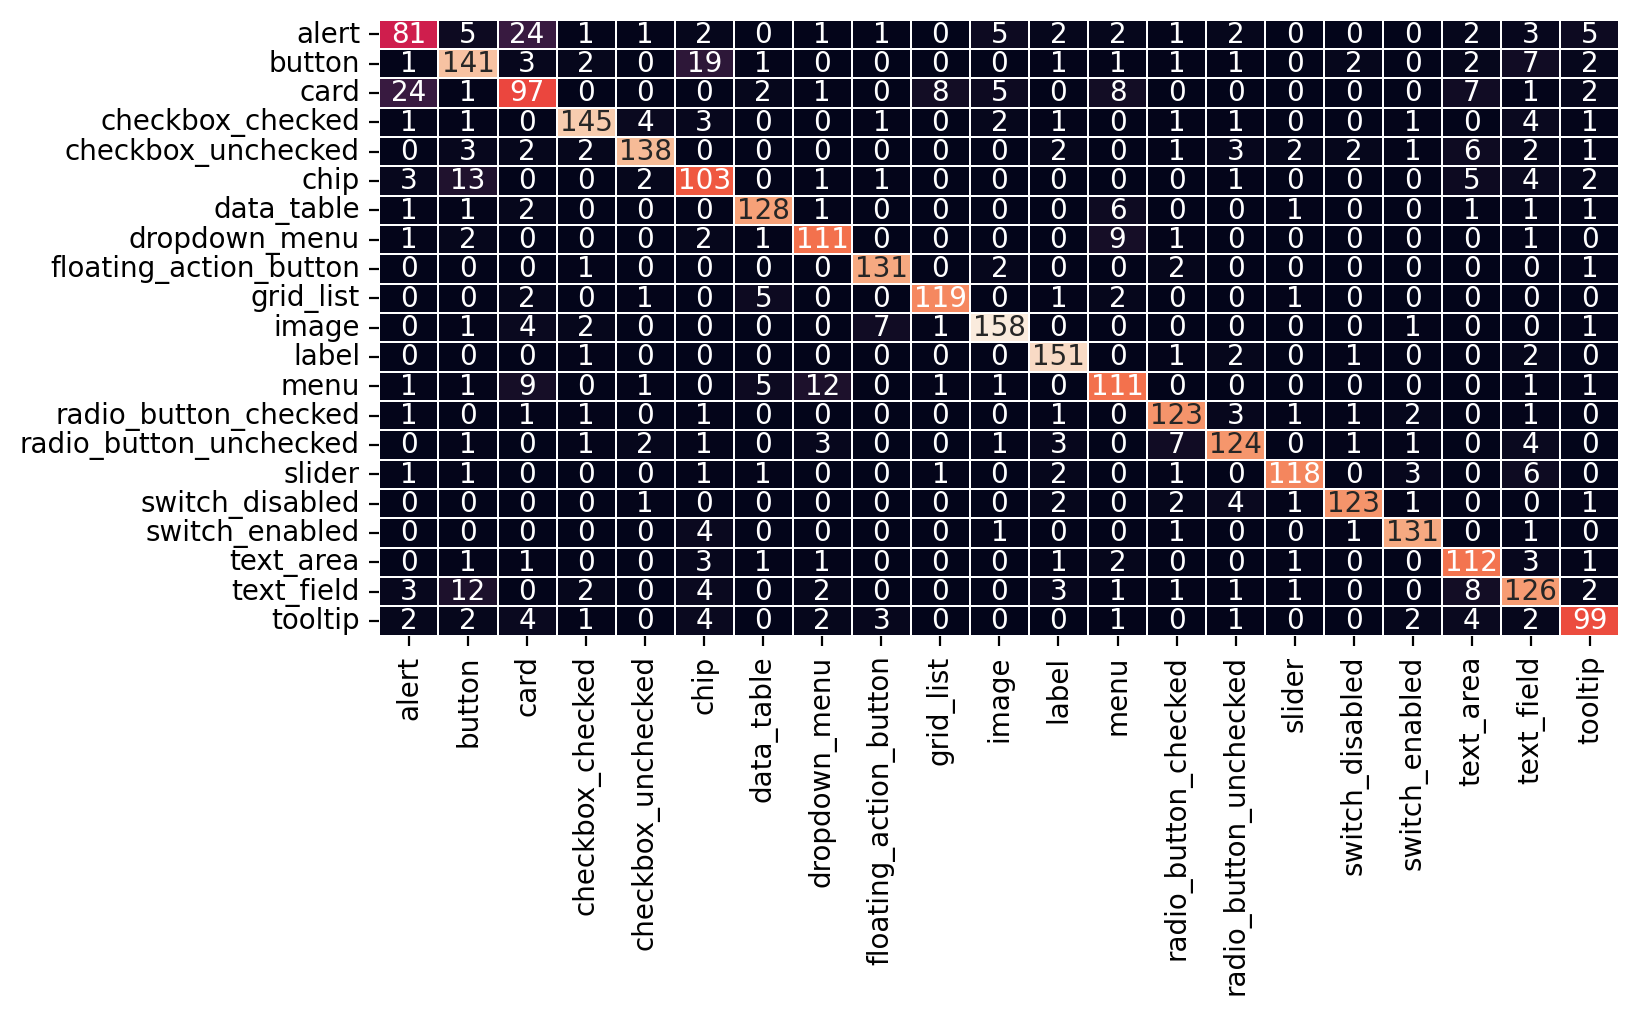

In [ ]:
show_prediction_results_deployed(model, validation_data)

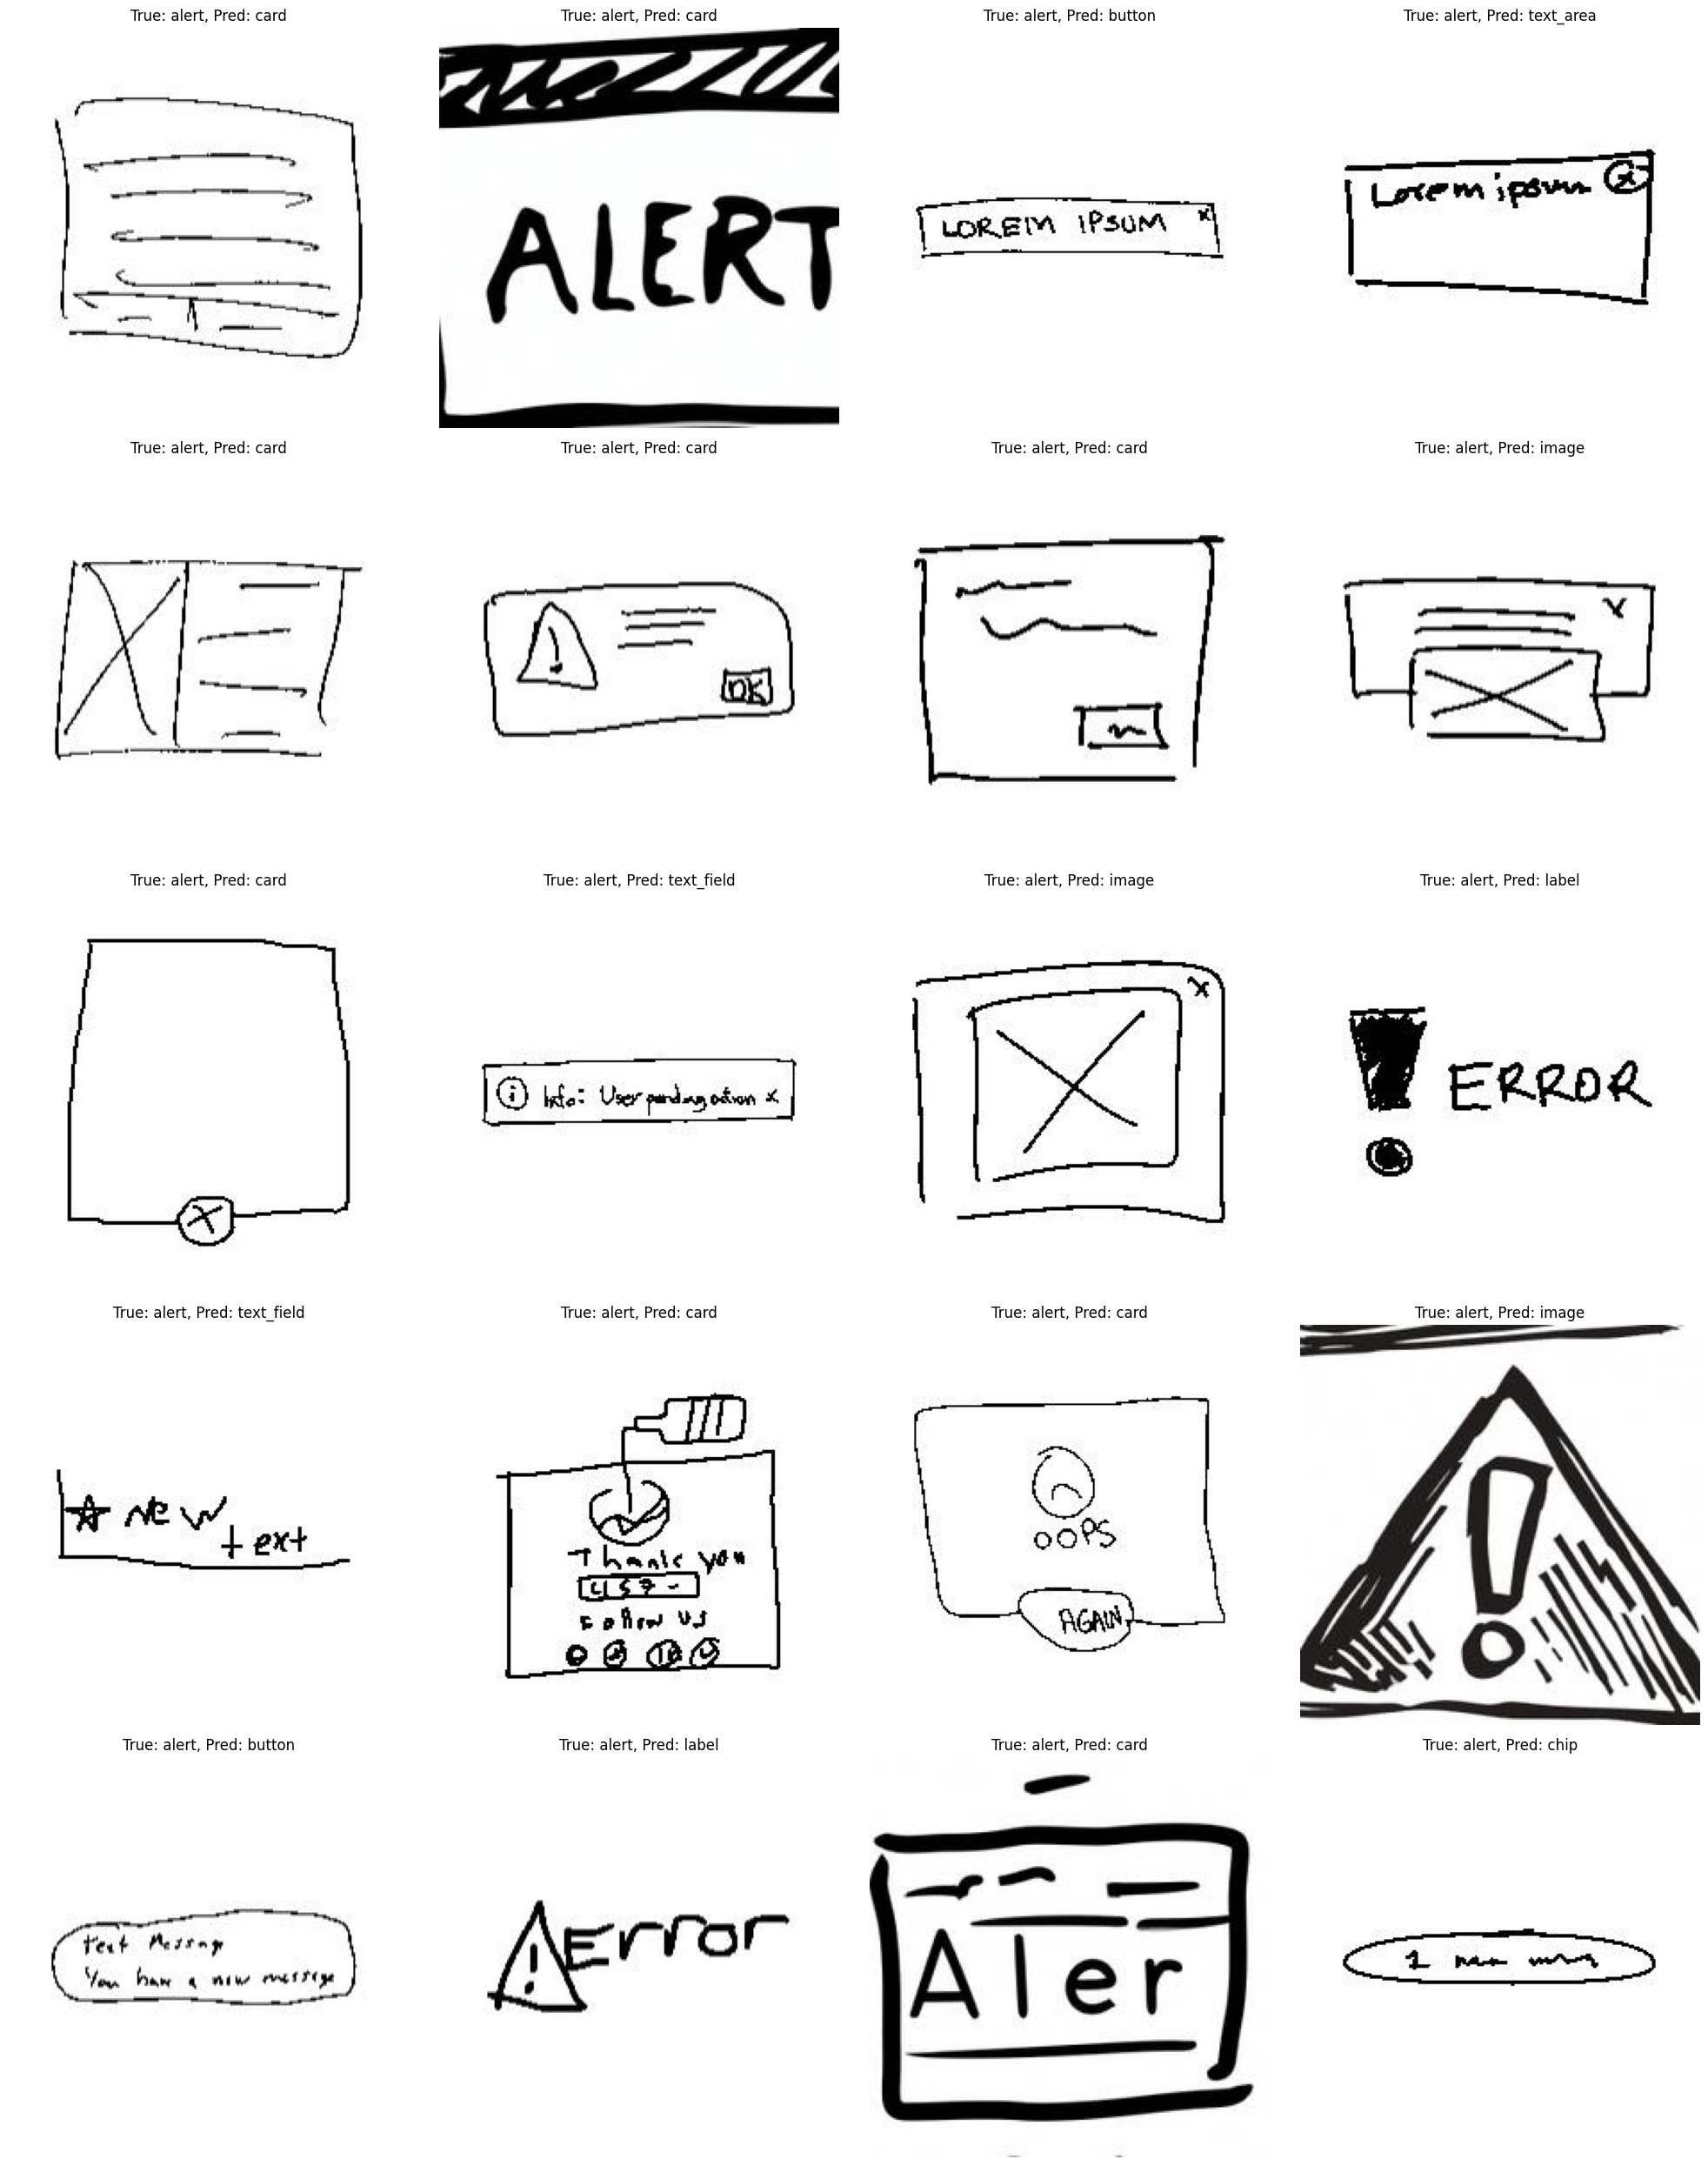

In [ ]:
plot_inccorectly_predicted_data(20)

In [ ]:
show_train_graphs(history1)

# Predict and Save Test Data

In [ ]:
def load_and_preprocess_images(img_paths, target_size=(224, 224)):
    batch_of_images = []
    for img_path in img_paths:
      img = image.load_img(img_path,
                          target_size=target_size,
                          color_mode='grayscale')
      img_array = image.img_to_array(img)
      # img_array = np.expand_dims(img_array, axis=0)
#       img_array = img_array / 255.0
      batch_of_images.append(img_array)
    return np.array(batch_of_images)

def predict_on_test_images(test_images_dir, model, batch_size=64):
    results = []
    dir_elems = os.listdir(test_images_dir)
    total_len = len(dir_elems)//batch_size
    for i in tqdm(range(total_len), total=total_len, desc="Predicting progress", unit="image_batch"):
        image_path_batch = []
        for j in range(batch_size):
          image_path_batch.append(os.path.join(test_images_dir, dir_elems[i*batch_size + j]))
        img_batch = load_and_preprocess_images(image_path_batch)
        prediction = model.predict(img_batch, verbose=0, batch_size=batch_size)
        predicted_class_indexs = np.argmax(prediction, axis=1)
        for j, predicted_class_index in enumerate(predicted_class_indexs):
          results.append([dir_elems[i*batch_size + j], class_names[predicted_class_index]])
    if len(dir_elems) % batch_size != 0:
        img_num = len(dir_elems) % batch_size
        image_path_batch = []
        for j in dir_elems[-batch_size:]:
          image_path_batch.append(os.path.join(test_images_dir, j))
        img_batch = load_and_preprocess_images(image_path_batch)
        prediction = model.predict(img_batch, verbose=0, batch_size=batch_size)
        predicted_class_indexs = np.argmax(prediction, axis=1)
        for nms, predicted_class_index in zip(dir_elems[-img_num:],predicted_class_indexs[-img_num:]):
          results.append([nms, class_names[predicted_class_index]])
    return results


results = predict_on_test_images(path_to_test, model)

Predicting progress: 100%|██████████| 80/80 [00:25<00:00,  3.15image_batch/s]


In [ ]:
import csv

def save_predictions_to_csv(results, output_csv_path):
    with open(output_csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ID', 'Target'])
        writer.writerows(results)


output_csv_path = 'predictions1.csv'
save_predictions_to_csv(results, output_csv_path)

print("Predictions have been saved to CSV.")

Predictions have been saved to CSV.
